In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
import yfinance as yf


In [4]:
df = yf.download('TSLA','2018-01-01','2023-01-01')



[*********************100%***********************]  1 of 1 completed


In [6]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,20.799999,21.474001,20.733334,21.368668,21.368668,65283000
2018-01-03,21.400000,21.683332,21.036667,21.150000,21.150000,67822500
2018-01-04,20.858000,21.236668,20.378668,20.974667,20.974667,149194500
2018-01-05,21.108000,21.149332,20.799999,21.105333,21.105333,68868000
2018-01-08,21.066668,22.468000,21.033333,22.427334,22.427334,147891000


In [8]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
df['Close'] = scaler.fit_transform(np.array(df['Close']).reshape(-1, 1))
df_train = df[df.index < '2022-01-01']
df_test = df[df.index >= '2022-01-01']


In [10]:
# Define the function that creates the model
def create_model(lstm_units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=lstm_units, return_sequences=True), input_shape=(30, 1)))
    model.add(Dropout(dropout_rate))
    model.add(Bidirectional(LSTM(units=lstm_units)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Create the KerasRegressor for use in scikit-learn

In [12]:

model = KerasRegressor(build_fn=create_model, verbose=0)


/tmp/ipykernel_10422/4274598069.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


In [13]:
param_grid = {
    'lstm_units': [32, 64, 128],
    'dropout_rate': [0.1, 0.2, 0.3]
}


## Hyper tunning my model using the gridsearch cv

In [14]:
X_train, y_train = [], []
for i in range(30, len(df_train)):
    X_train.append(df_train['Close'].iloc[i-30:i].values)
    y_train.append(df_train['Close'].iloc[i])
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = [], []
for i in range(30, len(df_test)):
    X_test.append(df_test['Close'].iloc[i-30:i].values)
    y_test.append(df_test['Close'].iloc[i])
X_test, y_test = np.array(X_test), np.array(y_test)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)


2023-04-08 10:54:45.552280: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-08 10:54:45.573794: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-08 10:54:45.632264: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

2023-04-08 10:54:47.019396: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-08 10:54:47.020252: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-04-08 10:54:47.020345: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2023-04-08 10:54:47.042753: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory


2023-04-08 10:56:45.214765: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-08 10:56:45.214788: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-08 10:56:45.214806: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kali): /proc/driver/nvidia/version does not exist
2023-04-08 10:56:45.215092: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
print('Best hyperparameters:', grid_result.best_params_)
y_pred = grid_result.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('Mean squared error:', mse)

# Train the final model on the training data with the best hyperparameters
model = create_model(lstm_units=grid_result.best_params_['lstm_units'], dropout_rate=grid_result.best_params_['dropout_rate'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

# Predict the stock prices on the testing data
y_pred = model.predict(X_test)

Best hyperparameters: {'dropout_rate': 0.1, 'lstm_units': 128}
Mean squared error: 0.011339666674096345
Epoch 1/100
28/28 [==============================] - 8s 102ms/step - loss: 0.0066 - val_loss: 0.0091
Epoch 2/100
28/28 [==============================] - 1s 53ms/step - loss: 0.0012 - val_loss: 0.0072
Epoch 3/100
28/28 [==============================] - 2s 55ms/step - loss: 7.6993e-04 - val_loss: 0.0058
Epoch 4/100
28/28 [==============================] - 2s 54ms/step - loss: 5.9367e-04 - val_loss: 0.0057
Epoch 5/100
28/28 [==============================] - 2s 59ms/step - loss: 5.5324e-04 - val_loss: 0.0049
Epoch 6/100
28/28 [==============================] - 2s 57ms/step - loss: 4.7539e-04 - val_loss: 0.0051
Epoch 7/100
28/28 [==============================] - 2s 56ms/step - loss: 5.1939e-04 - val_loss: 0.0058
Epoch 8/100
28/28 [==============================] - 2s 54ms/step - loss: 5.6960e-04 - val_loss: 0.0039
Epoch 9/100
28/28 [==============================] - 2s 55ms/step - los

In [17]:
y_pred = model.predict(X_test)

7/7 [==============================] - 0s 16ms/step


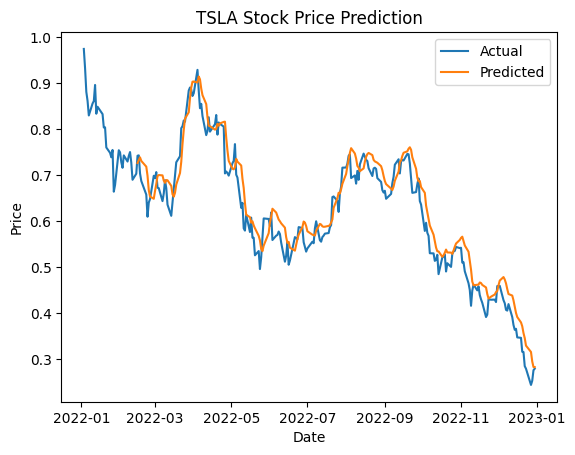

In [19]:
plt.plot(df_test.index, df_test['Close'], label='Actual')
plt.plot(df_test.index[30:], y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('TSLA Stock Price Prediction')
plt.legend()
plt.show()
